In [1]:
from copy import copy,deepcopy
from itertools import combinations
import json
import textwrap


from fisher import pvalue_npy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
import requests
import requests_cache


requests_cache.install_cache(
    "pfocr_cache",
    allowable_methods=['GET', 'POST'],
    stale_if_error=False,
)
#requests_cache.remove_expired_responses()

# BTE Cluster by All TRAPI Curies Fisher Exact Test

TLDR: skip ahead to the "View TRAPI results and figures" section.

Note this currently only works on queries with nodes of categories supported by PFOCR, e.g., `biolink:Gene`, `biolink:SmallMolecule`, `biolink:Disease`. TODO: update the Fisher's Exact test to work with node categories not in PFOCR.

## Get BTE TRAPI Results

In [3]:
query = {
    "message": {
        "query_graph": {
            "edges": {
                "e0": {
                    "subject": "n0",
                    "object": "n1",
                    "predicates": [
                        "biolink:entity_regulates_entity",
                        "biolink:genetically_interacts_with"
                    ]
                },
                "e1": {
                    "subject": "n1",
                    "object": "n2",
                    "predicates": [
                        "biolink:related_to"
                    ]
                }
            },
            "nodes": {
                "n0": {
                    "ids": [
                        "NCBIGene:5872"
                    ],
                    "categories": [
                        "biolink:Gene"
                    ]
                },
                "n1": {
                    "categories": [
                        "biolink:Gene"
                    ],
                },
                "n2": {
                    "categories": [
                        "biolink:SmallMolecule"
                    ]
                }
            }
        }
    }
}

trapi_response = requests.post("http://localhost:3000/v1/query", json=query)
#trapi_response = requests.post("https://api.bte.ncats.io/v1/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/rtxkg2/v1.2/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/arax/v1.2/query", json=query)
print(trapi_response.status_code)
if trapi_response.status_code != 200:
    raise Exception(trapi_response.text)
if trapi_response.from_cache:
    print(f"got response from cache")

trapi_message = trapi_response.json()["message"]

if len(trapi_message["results"]) == 0:
    raise Exception(f'No results returned')

200
got response from cache


Analyze this GraphML file in Cytoscape: ./bte_sleeve_query_template.graphml


{('n0',
  'n1'): Text(-0.18103945782702552, -0.4999999999999999, 'biolink:entity_regulates_entity\nbiolink:genetically_interacts_with'),
 ('n1',
  'n2'): Text(0.18102239751539337, 0.4999528985130864, 'biolink:related_to')}

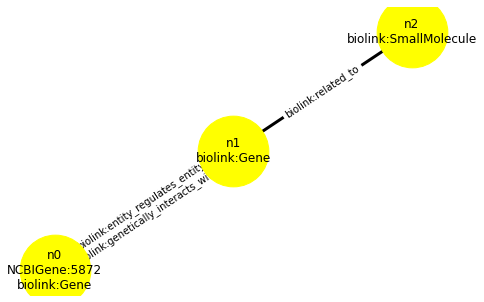

In [4]:
from collections import defaultdict


G = nx.Graph()
query_node_labels = {}
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    node_categories = v.get('categories', [])
    G.add_node(k, categories=', '.join(node_categories))
    query_node_labels[k] = '\n'.join([k] + node_ids + node_categories)
    #G.add_node(k, color='red')

query_edge_labels = {}
q_node_id_keys = set(['object', 'subject'])
for q_edge_id,edge_v in query['message']['query_graph']['edges'].items():
    for predicate in edge_v['predicates']:
        G.add_edge(edge_v['subject'], edge_v['object'], predicate=predicate)
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=', '.join(edge_v['predicates']))
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=[1,2,3])
    #G.add_edge(edge_v['subject'], edge_v['object'])
    query_edge_labels[(edge_v['subject'], edge_v['object'])] = '\n'.join(edge_v['predicates'])
    
query_template_f = './bte_sleeve_query_template.graphml'
print(f'Analyze this GraphML file in Cytoscape: {query_template_f}')
nx.write_graphml(G, query_template_f)

options = {
    'node_color': 'yellow',
    'node_size': 5000,
    'edge_color': 'black',
    'width': 3,
}
query_template_layout = nx.spring_layout(G)
nx.draw(G, pos=query_template_layout, **options)
nx.draw_networkx_labels(G, query_template_layout, labels=query_node_labels, font_size=12,
                        font_color='k', font_family='sans-serif',
                        font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                        verticalalignment='center', ax=None, clip_on=False)
nx.draw_networkx_edge_labels(G, pos=query_template_layout,
                             edge_labels=query_edge_labels,
                             label_pos=0.5, 
                             font_size=10, font_color='k', font_family='sans-serif',
                             font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                             verticalalignment='center', ax=None, rotate=True, clip_on=True)

In [5]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

curie_categories = set()
for v in query["message"]["query_graph"]["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [6]:
# for genes/gene products, chemicals and diseases
preferred_prefixes = set(["NCBIGene", "MESH"])
trapi_results_unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    for category in v["categories"]:
        curie_categories.add(category)
        
    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]
            
            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")
            
            unified_curie = None
            intersecting_trapi_results_unified_curies = trapi_results_unified_curies.intersection(set(curies))
            if len(intersecting_trapi_results_unified_curies) > 1:
                raise Exception(f"matching multiple: {k} to {list(intersecting_trapi_results_unified_curies)}")
            elif len(intersecting_trapi_results_unified_curies) == 1:
                unified_curie = list(intersecting_trapi_results_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        trapi_results_unified_curies.add(unified_curie)
                        break
                        
            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break
                    
                #raise Exception(f"failed to find a unified curie for {k} in {curies}")
                
            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)
            
            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")
                    #raise Exception(f"curie{curie} has multiple names: {curie_to_name[curie]} and {name}")


#print(f'curie_categories: {curie_categories}')
#print("")
#print(f"curie_to_name key count: {len(curie_to_name.keys())}")
#print(f"curie_to_unified_curie key count: {len(curie_to_unified_curie.keys())}")
#print("")
print("all CURIE prefixes found:")
print(all_prefixes)
print("")
print("unified CURIE prefixes found:")
print(unified_prefixes)
print("")
print(f"failed to unify {len(unification_failed_curies)} CURIEs")

curie UMLS:C0903898 has multiple primary names: NATEGLINIDE and nateglinide
curie UMLS:C0021641 has multiple primary names: Iletin and Insulin
all CURIE prefixes found:
{'PUBCHEM.COMPOUND', 'PR', 'DrugCentral', 'CHEBI', 'NCBIGene', 'GTOPDB', 'HGNC', 'DRUGBANK', 'MESH', 'KEGG.COMPOUND', 'UMLS', 'CHEMBL.COMPOUND', 'OMIM', 'HMDB', 'UNII', 'ENSEMBL', 'INCHIKEY', 'UniProtKB', 'CAS'}

unified CURIE prefixes found:
{'MESH', 'NCBIGene'}

failed to unify 886 CURIEs


In [7]:
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["message"]["query_graph"]["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)
                
query_nodes_with_ids = set()
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        query_nodes_with_ids.add(k)
                
for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_curie")
    columns.append(f"{q_node_id}_unified_curie")
    
columns.append("trapi_result_curie_combo")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

unified_curie_columns = []
for q_node_id in q_node_ids:
    unified_curie_columns.append(f"{q_node_id}_unified_curie")

In [8]:
trapi_results = trapi_message["results"]

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)
        
    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curies = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")
            
            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curies.add(unified_curie)
                    row_data_template[qnode_id + "_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie
                    
    if len(trapi_result_curies) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue
        
    row_data_template["trapi_result_curie_combo"] = tuple(sorted(trapi_result_curies))
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas
        
print("warning: predicate direction(s) may be switched")
results_df = pd.DataFrame.from_records(result_row_data, columns=columns).drop_duplicates()
results_df

,n0,e0,n1,e1,n2,n0_curie,n0_unified_curie,n1_curie,n1_unified_curie,n2_curie,n2_unified_curie,trapi_result_curie_combo
0,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,WATER,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,CHEMBL.COMPOUND:CHEMBL1098659,MESH:D014867,"(MESH:D014867, NCBIGene:22931, NCBIGene:5872)"
1,RAB13,entity_positively_regulates_entity,RAB18,entity_negatively_regulated_by_entity,WATER,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,CHEMBL.COMPOUND:CHEMBL1098659,MESH:D014867,"(MESH:D014867, NCBIGene:22931, NCBIGene:5872)"
2,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Isopropyl-beta-D-thiogalactopyranoside,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:656894,MESH:D007544,"(MESH:D007544, NCBIGene:22931, NCBIGene:5872)"
3,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Trichostatin A,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:444732,MESH:C012589,"(MESH:C012589, NCBIGene:22931, NCBIGene:5872)"
4,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Mannitol,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:6251,MESH:D008353,"(MESH:D008353, NCBIGene:22931, NCBIGene:5872)"
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,RAB13,genetically_interacts_with,TGFBR1,coexists_with,5' Flanking Region,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,UMLS:C0949645,MESH:D024506,"(MESH:D024506, NCBIGene:5872, NCBIGene:7046)"
6126,RAB13,genetically_interacts_with,TGFBR1,coexists_with,"1,3,4,6-Tetra-O-acetyl-2-azido-2-deoxy-beta-D-...",NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:133445,MESH:C070423,"(MESH:C070423, NCBIGene:5872, NCBIGene:7046)"
6127,RAB13,genetically_interacts_with,TGFBR1,increases_response_to,Thioacetamide,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:2723949,MESH:D013853,"(MESH:D013853, NCBIGene:5872, NCBIGene:7046)"
6128,RAB13,genetically_interacts_with,TGFBR1,affects_response_to,Thioacetamide,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:2723949,MESH:D013853,"(MESH:D013853, NCBIGene:5872, NCBIGene:7046)"


Unique CURIE count per query node:

In [9]:
for q_node_id in q_node_ids:
    print(f'{q_node_id}: {len(set(results_df[q_node_id]))}')

n0: 1
n1: 12
n2: 1347


Total results count (excluding any that couldn't be unified):

In [10]:
len(set(results_df["trapi_result_curie_combo"]))

3158

That's too too high for a researcher to efficiently go through manually. Let's try filtering to make that more manageable.

## Match up BTE TRAPI Results & PFOCR

We're going to try using PFOCR to filter and prioritize the results.

First we need to get the PFOCR Data. We could get it from the API, but for now, we'll just go ahead and download the entire JSON file we gave to BTE.

In [11]:
pfocr_url = "https://www.dropbox.com/s/1f14t5zaseocyg6/bte_chemicals_diseases_genes.ndjson?dl=1"
pfocr_request = requests.get(pfocr_url)
print(f"status_code: {pfocr_request.status_code}")
if pfocr_request.status_code != 200:
    print(pfocr_request.text)

status_code: 200


In [12]:
figures_df_data = []
curies_to_figure_ids = {}
figure_id_to_curies = {}
figure_id_to_pfocr_result = {}
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    curies_key = tuple(sorted(curies))
    
    figures_df_data.append({
        "figure_id": figure_id,
        "curie_combo": curies_key,
    })
    
    if curies_key not in curies_to_figure_ids:
        curies_to_figure_ids[curies_key] = []
    curies_to_figure_ids[curies_key].append(figure_id)

figures_df = pd.DataFrame.from_records(figures_df_data)
figures_df

,figure_id,curie_combo
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,"(NCBIGene:10131, NCBIGene:1051, NCBIGene:10563..."
1,PMC5793760__cshperspect-TGF-022210_F4.jpg,"(NCBIGene:151449, NCBIGene:2657, NCBIGene:2658..."
2,PMC5793761__cshperspect-TGF-031989_F1.jpg,"(NCBIGene:1432, NCBIGene:151449, NCBIGene:1686..."
3,PMC5830892__cshperspect-CEL-027961_F2.jpg,"(NCBIGene:2119, NCBIGene:55249, NCBIGene:58, N..."
4,PMC5830900__cshperspect-TGF-031997_F1.jpg,"(MESH:D011374, NCBIGene:151449, NCBIGene:2657,..."
...,...,...
77714,PMC2804790__253_2009_2262_Fig1_HTML.jpg,"(MESH:C018475, MESH:C031105, MESH:C043801, MES..."
77715,PMC6332787__thnov09p0126g006.jpg,"(NCBIGene:29126, NCBIGene:5133, NCBIGene:6387,..."
77716,PMC5807036__IJO-52-03-0787-g01.jpg,"(NCBIGene:1977, NCBIGene:22937, NCBIGene:2313,..."
77717,PMC6770832__cancers-11-01236-g005.jpg,"(NCBIGene:1432, NCBIGene:4086, NCBIGene:4087, ..."


## Fisher Exact Test -- all BTE TRAPI CURIES

All BTE TRAPI CURIEs
From discussion with Andrew.

In [21]:
all_genes = set()
gene_instance_count = 0
all_chemicals = set()
chemical_instance_count = 0
all_diseases = set()
disease_instance_count = 0
for figure_id, pfocr_result in figure_id_to_pfocr_result.items():
    genes = pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]
    for gene in genes:
        gene_instance_count += 1
        all_genes.add(gene)

    chemicals = pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]
    for chemical in chemicals:
        chemical_instance_count += 1
        all_chemicals.add(chemical)

    diseases = pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]
    for disease in diseases:
        disease_instance_count += 1
        all_diseases.add(disease)

#print("total instance counts:")
#print(f'  chemicals: {chemical_instance_count}')
#print(f'  diseases: {disease_instance_count}')
#print(f'  genes: {gene_instance_count}')

#print("")

#print("unique counts:")
#print(f'  chemicals: {len(all_chemicals)}')
#print(f'  diseases: {len(all_diseases)}')
#print(f'  genes: {len(all_genes)}')

#print("")

curie_category_to_curies = {
    "biolink:ChemicalEntity": all_chemicals,
    "biolink:SmallMolecule": all_chemicals,
    "biolink:Disease": all_diseases,
    "biolink:Gene": all_genes,
}


all_figure_curies = set()
for curie_category in set(curie_category_to_curies.keys()).intersection(curie_categories):
    all_figure_curies |= curie_category_to_curies[curie_category]
all_figure_curie_count = len(all_figure_curies)

print(f'Count for all unique CURIEs seen in all figures: {all_figure_curie_count}')

Count for all unique CURIEs seen in all figures: 28735


In [15]:
len(trapi_results_unified_curies)

1362

In [14]:
curies_in_sample_figure = figures_df[figures_df["figure_id"] == "PMC6361031__13205_2019_1598_Fig1_HTML.jpg"]["curie_combo"].tolist()[0]
print(curies_in_sample_figure)
print(len(curies_in_sample_figure))

('MESH:C010667', 'MESH:C018475', 'MESH:C041787', 'MESH:C043941', 'MESH:C065987', 'MESH:D000079', 'MESH:D000085', 'MESH:D000090', 'MESH:D000096', 'MESH:D000105', 'MESH:D000431', 'MESH:D000440', 'MESH:D002087', 'MESH:D009243')
14


In [16]:
sample_intersection = trapi_results_unified_curies.intersection(set(curies_in_sample_figure))
print(sample_intersection)
print(len(sample_intersection))

{'MESH:D009243', 'MESH:D000431', 'MESH:D000085', 'MESH:D000079', 'MESH:C043941'}
5


For figure PMC6361031__13205_2019_1598_Fig1_HTML.jpg for the all TRAPI CURIEs case:

|                      | IN THIS FIG | NOT IN THIS FIG  | Total        |
|----------------------|-------------|------------------|--------------|
| IN TRAPI RESULTS     | 5           | 1362 - 5         | 1362         |
| NOT IN TRAPI RESULTS | 9           | 28735 - 1362 - 9 | 28735 - 1362 |
| Total                | 14          | 28735 - 14       | 28735        |

In [17]:
figures_df["figure_curie_count"] = figures_df["curie_combo"].map(len)
figures_df["figure_curies_in_trapi_results"] = figures_df["curie_combo"].map(lambda curie_combo: trapi_results_unified_curies.intersection(set(curie_combo)))


# number of CURIEs in both TRAPI results and figure
figures_df["yes_trapi_results_yes_figure"] = figures_df["figure_curies_in_trapi_results"].map(len)

# number of CURIEs in TRAPI results but not in figure 
figures_df["yes_trapi_results_no_figure"] = len(trapi_results_unified_curies) - figures_df["yes_trapi_results_yes_figure"]

# number of CURIEs not in TRAPI results but in figure 
figures_df["no_trapi_results_yes_figure"] = figures_df["figure_curie_count"] - figures_df["yes_trapi_results_yes_figure"]

# number of CURIEs not in TRAPI results and not in figure 
figures_df["no_trapi_results_no_figure"] = all_figure_curie_count - len(trapi_results_unified_curies) - figures_df["no_trapi_results_yes_figure"]

In [18]:
# see https://stackoverflow.com/a/58661068/5354298

_, _, twosided = pvalue_npy(
    figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
    figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
    figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
    figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
)
# TODO: do we need the odds ratio?
#odds = (
#    figures_df["yes_trapi_results_yes_figure"].to_numpy('uint') *
#    figures_df["no_trapi_results_no_figure"].to_numpy('uint')
#) / (
#    figures_df["yes_trapi_results_no_figure"].to_numpy('uint') *
#    figures_df["no_trapi_results_yes_figure"].to_numpy('uint')
#)

figures_df["p_value"] = pd.Series(twosided, index=figures_df.index)
figures_df["p_value"].sort_values()

17099    5.601158e-08
17461    5.601158e-08
51396    5.601158e-08
54833    5.804763e-08
60679    5.804763e-08
             ...     
46540    1.000000e+00
58755    1.000000e+00
3512     1.000000e+00
67356    1.000000e+00
70025    1.000000e+00
Name: p_value, Length: 77719, dtype: float64

(array([14557.,  5886.,  5699.,  2819.,  5719.,  2090.,  6270.,  1377.,
           81., 33221.]),
 array([5.60115811e-08, 1.00000050e-01, 2.00000045e-01, 3.00000039e-01,
        4.00000034e-01, 5.00000028e-01, 6.00000022e-01, 7.00000017e-01,
        8.00000011e-01, 9.00000006e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

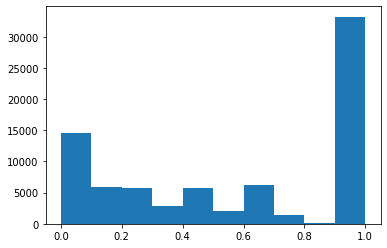

In [19]:
plt.hist(
    figures_df["p_value"]
)

In [24]:
len(figures_df[figures_df["p_value"] < 0.05])

10798

TODO NEXT:
1. For the figure most associated with all the TRAPI results, get the individual TRAPI results most similar to it.
2. Display the figure and the top 10 TRAPI results
3. Maybe find the next figure most closely associated with the remaining TRAPI results and then plot it with the top 10 TRAPI results associated with it?

Maybe display the main figure large but also include several other related figures under it in a small format, along with the top 10 TRAPI results?